In [68]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [69]:
def one_hot(y,n_output):
    y_ret = [];
    for i in y:
        val = np.zeros(n_output)
        val[i] = 1;
        y_ret.append(val);
    return np.array(y_ret)

In [70]:
def gen_weights(mu_mat,layer_wise_neurons,sigma):
    l = len(mu_mat)
    weights_by_layer = dict()
    for i in range(l):
        #print(type(i))
        #print(layer_wise_neurons)
        weights = np.zeros((layer_wise_neurons[i],layer_wise_neurons[i+1]))
        for j in range(layer_wise_neurons[i+1]):
            weights[:,j] = np.random.normal(mu_mat[i][j],sigma[i][j],layer_wise_neurons[i])
            weights[:,j] = weights[:,j]
        weights_by_layer[i] = weights
    return weights_by_layer

In [71]:
def activation(s,type_= 0):
    if(type_==1):
        return 1/(1+np.exp(-s))
    else:
        return np.where(s>=0,s,0)
def forward(weights_by_layers,x):
    l = len(weights_by_layers)
    a = x
    collected_weights = dict()
    for i in range(l):
        w = weights_by_layers[i]
        #print(w)
        #print("=======ok now========")
        #print(a)
        z = np.matmul(w.T,a)
        a = activation(z,1)
        #collected_weights[i] = a
    return a

In [72]:
def update(mu_mat,store,tot_err,chosen_index):
    val = np.sum(tot_err[chosen_index])
    mu_mat = (1-gamma)*mu_mat
    #print("chosen index:",chosen_index[0])
    #chosen_index = chosen_index[0]
    for i in range(len(chosen_index)):
        weights_dist = store[chosen_index[i]]
        err = tot_err[chosen_index[i]]
        #print("Error:",tot_err)
        for x in weights_dist:
            weights_dist[x] = weights_dist[x]*err/val
            mu_new = np.mean(weights_dist[x],axis=0)
            mu_mat[x] = mu_mat[x] + gamma*mu_new
    return mu_mat

In [97]:
class RBNN:
    def __init__(self,n_layers,mu_mat,nj_list,rho,alyer_wise_neurons,sigma):
        self.n_layers = n_layers
        self.mu_mat = mu_mat
        self.nj_list = nj_list
        self.rho = rho
        self.layer_wise_neurons = alyer_wise_neurons
        self.sigma_mat = sigma
    def activation(self,s):
        return np.where(s>=0,s,0)
    def error(self,y,y_hat):
        return -np.dot(y,np.log(y_hat))       
    def CEO(self,nj):
        store=[];tot_err=[];acc_list = []
        for j in range(nj):
            weights_by_layer = gen_weights(self.mu_mat,self.layer_wise_neurons,self.sigma_mat)
            store.append(weights_by_layer)
            error = 0
            acc = 0;
            for (x,y) in zip(self.X,self.y_):
                y_hat = forward(weights_by_layer,x)
                #print("Predicted:",y_hat)
                error = error + np.sum(self.error(y,y_hat))
                #print("predicted:",y_hat,"actual:",y)
                #input()
                acc = acc+ (np.argmax(y_hat)==np.argmax(y))
                #print("Yhat,error,acc:",y_hat,error,acc)
                #input()
            tot_err.append(error/len(self.y_))
            acc_list.append(acc)
        acc_list,tot_err = np.array(acc_list),np.array(tot_err)
        #print(np.sort(tot_err))
        #print(np.argsort(tot_err))
        chosen_index = np.argsort(tot_err)[0:int(self.rho*nj)]
        #print("first chosen index",chosen_index)
        self.mu_mat = update(self.mu_mat,store,tot_err,chosen_index)
        print("Mean matrix:",self.mu_mat)
        return np.mean(tot_err[chosen_index]),np.mean(acc_list[chosen_index])
    def train(self,X,y_):
        self.X = X
        self.y_ = y_
        err_plot,acc_plot=[],[]
        for nj in tqdm(nj_list):
            train_err,acc = self.CEO(nj)
            print("Train error {}".format(train_err))
            err_plot.append(train_err)
            acc_plot.append(acc)
        #print("Before returning:",self.mu_mat)
        return err_plot,acc_plot,self.mu_mat,self.sigma_mat
    def predict(self,X,y_):
        weights_by_layer = gen_weights(self.mu_mat,self.layer_wise_neurons,self.sigma_mat)
        print("weights: by :",weights_by_layer)
        print("input:",X)
        y_hat = forward(weights_by_layer,X)
        print("Actual output:{} and predicted ouput:{}".format(np.argmax(y_),np.argmax(y_hat)))

# PULSAR TESTING

In [113]:
##Declaring hyperparameters
gamma = 0.8
nj_list = np.arange(10,400,10)
rho = 0.1
n_features = 3
n_output = 2
layer_wise_neurons = [n_features,2,2,n_output]
mu_mat = []
sigma_mat = []
for i in range(len(layer_wise_neurons)-1):
    mu_mat.append(np.ones(layer_wise_neurons[i+1])*0)
    sigma_mat.append(np.ones(layer_wise_neurons[i+1]))
mu_mat = np.array(mu_mat)
sigma_mat = np.array(sigma_mat)
#X = np.array([[0.1,0.2,0.3],
#              [5,6,7]])
#y = np.array([[0],[1]])
print(mu_mat)

[[0. 0.]
 [0. 0.]
 [0. 0.]]


In [114]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
path = "D://datasets//Pulsar//Pulsar_reduced.xlsx"
data = pd.read_excel(path)
y = data['label'].to_numpy()
X = data.drop(['label'],axis=1).to_numpy()
scaler = StandardScaler()
X_new = scaler.fit_transform(X)
y = one_hot(y,n_output)

In [115]:
nj_list = np.arange(100,600,50)
model2 = RBNN(len(layer_wise_neurons),mu_mat,nj_list,rho,layer_wise_neurons,sigma_mat)
err_plot,acc_plot,mu_mat,sigma_mat = model2.train(X_new,y)

 10%|████████▎                                                                          | 1/10 [00:41<06:15, 41.76s/it]

Mean matrix: [[-0.00925002  0.06816611]
 [ 0.20712929 -0.00822678]
 [ 0.87717086  0.12018392]]
Train error 0.2919544718478633


 20%|████████████████▌                                                                  | 2/10 [01:43<07:10, 53.75s/it]

Mean matrix: [[0.15779008 0.11511916]
 [0.47557907 0.36546361]
 [1.69992571 0.23101465]]
Train error 0.1403341112866251


 30%|████████████████████████▉                                                          | 3/10 [03:17<08:24, 72.03s/it]

Mean matrix: [[ 0.14564038 -0.10082359]
 [ 0.52223755  0.84205302]
 [ 2.48993154  0.66887111]]
Train error 0.05447728559480033


 40%|█████████████████████████████████▏                                                 | 4/10 [05:03<08:32, 85.48s/it]

Mean matrix: [[ 0.21515419 -0.18742346]
 [ 0.81919614  1.00926278]
 [ 3.02022869  1.08141935]]
Train error 0.030444035400385653


 50%|█████████████████████████████████████████                                         | 5/10 [07:15<08:31, 102.23s/it]

Mean matrix: [[ 0.07927049 -0.21371062]
 [ 1.11878882  1.28339315]
 [ 3.47436923  1.68020329]]
Train error 0.01152806267462657


 60%|█████████████████████████████████████████████████▏                                | 6/10 [09:42<07:49, 117.28s/it]

Mean matrix: [[ 0.17578792 -0.33260289]
 [ 1.44544119  1.51094549]
 [ 4.03958566  2.28231628]]
Train error 0.0034999917013962844


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [12:28<06:39, 133.30s/it]

Mean matrix: [[ 0.23471008 -0.30307695]
 [ 1.96291925  1.76653852]
 [ 4.51068435  2.77334786]]
Train error 0.0013061366049403485


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [15:39<05:03, 151.80s/it]

Mean matrix: [[ 0.23687852 -0.33853039]
 [ 2.1616838   1.97987743]
 [ 4.97316894  3.41464366]]
Train error 0.00047440337446964434


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [19:21<02:53, 173.55s/it]

Mean matrix: [[ 0.25418338 -0.23613172]
 [ 2.33663202  2.24126112]
 [ 5.38096433  3.94153905]]
Train error 0.00017175974042113503


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [23:29<00:00, 140.97s/it]

Mean matrix: [[ 0.37108269 -0.1548134 ]
 [ 2.67406912  2.36251707]
 [ 5.82106703  4.39328733]]
Train error 5.5285138972066605e-05


In [121]:
loss_dictionary={'RBNN':err_plot}
df = pd.DataFrame(loss_dictionary)
df.to_excel('Pulsar_Loss_Restricted_BNN.xlsx')

In [120]:
choice = np.random.choice(len(X_new),(1,10))[0]
print(choice)
for i in choice:
    model2.predict(X_new[i],y[i])

[ 762 5757 3418 3960 9276 9059 1315 1844 6165 2566]
weights: by : {0: array([[-0.44979298, -1.35410743],
       [-1.86347617, -0.68360565],
       [ 2.97712438, -0.56025894]]), 1: array([[2.30567238, 1.32010273],
       [2.45627999, 2.92038408]]), 2: array([[5.9596366 , 4.48835339],
       [6.66687662, 3.85361663]])}
input: [-1.52121289 -0.60428945 -1.0110199 ]
Actual output:0 and predicted ouput:0
weights: by : {0: array([[-0.7121372 , -0.10972797],
       [ 0.83249864, -1.35394389],
       [-0.66986958,  0.83625737]]), 1: array([[0.93111636, 2.76246943],
       [2.68203076, 4.74079205]]), 2: array([[4.9504538 , 6.23102158],
       [4.10742335, 3.16634137]])}
input: [-0.14005168  0.3597898  -0.13522812]
Actual output:0 and predicted ouput:1
weights: by : {0: array([[-0.06246186, -1.04813296],
       [-0.30921512,  0.18781475],
       [ 1.80945279, -0.58565685]]), 1: array([[1.97160969, 2.3006509 ],
       [3.36591271, 0.88916423]]), 2: array([[5.00551104, 6.10655519],
       [7.376692

In [123]:
total_accuracy = 0
for i in X_new:
    weights_by_layer = gen_weights(mu_mat,layer_wise_neurons,sigma_mat)
    y_hat = forward(weights_by_layer,i)
    total_accuracy = total_accuracy + (np.argmax(y_hat)==np.argmax(y))
print("Accuracy:",total_accuracy/len(X_new))

Accuracy: 0.922014687100894


# IRIS TESTING

In [105]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
path = "D://datasets//iris//iris.xlsx"
data = pd.read_excel(path)
y = data['label'].to_numpy()
X = data.drop(['label'],axis=1).to_numpy()

gamma = 0.5
nj_list = np.arange(100,600,20)
rho = 0.15
n_features = 4
n_output = 3
scaler = StandardScaler()
X_new = scaler.fit_transform(X)
y = one_hot(y,n_output)
layer_wise_neurons = [n_features,2,2,n_output]
mu_mat = []
sigma_mat = []
for i in range(len(layer_wise_neurons)-1):
    mu_mat.append(np.zeros(layer_wise_neurons[i+1]))
    sigma_mat.append(np.ones(layer_wise_neurons[i+1]))
mu_mat = np.array(mu_mat)
sigma_mat = np.array(sigma_mat)
#print(mu_mat)
model2 = RBNN(len(layer_wise_neurons),mu_mat,nj_list,rho,layer_wise_neurons,sigma_mat)
err_plot,acc_plot,mu_mat,sigma_mat = model2.train(X_new,y)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\anaconda\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  4%|███▎                                                                               | 1/25 [00:00<00:12,  1.95it/s]

Mean matrix: [array([-0.03840415,  0.07841919]) array([0.08610812, 0.12798007])
 array([0.14789558, 0.34874182, 0.18671871])]
Train error 0.4827631815620031


  8%|██████▋                                                                            | 2/25 [00:01<00:13,  1.73it/s]

Mean matrix: [array([-0.09676993,  0.16765601]) array([0.16443727, 0.33189349])
 array([0.38256951, 0.59753177, 0.48766249])]
Train error 0.37260887572851564


 12%|█████████▉                                                                         | 3/25 [00:01<00:14,  1.56it/s]

Mean matrix: [array([-0.01025867,  0.18484306]) array([0.22780773, 0.39437714])
 array([0.71209869, 0.74387161, 0.73529863])]
Train error 0.314771712944906


 16%|█████████████▎                                                                     | 4/25 [00:02<00:14,  1.41it/s]

Mean matrix: [array([0.04079311, 0.25237837]) array([0.32092155, 0.6261954 ])
 array([0.96934754, 0.95484347, 1.00181078])]
Train error 0.21123011332344


 20%|████████████████▌                                                                  | 5/25 [00:03<00:15,  1.28it/s]

Mean matrix: [array([0.00214575, 0.22308941]) array([0.50380525, 0.88590939])
 array([1.16262155, 1.23489766, 1.23188138])]
Train error 0.15409652266780285


 24%|███████████████████▉                                                               | 6/25 [00:04<00:16,  1.17it/s]

Mean matrix: [array([0.08337371, 0.21770686]) array([0.70931142, 1.08012701])
 array([1.42202987, 1.47063765, 1.41752701])]
Train error 0.10081297267422683


 28%|███████████████████████▏                                                           | 7/25 [00:05<00:16,  1.07it/s]

Mean matrix: [array([0.07318405, 0.21443011]) array([0.80586951, 1.25768288])
 array([1.67851436, 1.76485314, 1.66956936])]
Train error 0.06552274293485727


 32%|██████████████████████████▌                                                        | 8/25 [00:06<00:17,  1.01s/it]

Mean matrix: [array([0.10806809, 0.12593335]) array([0.90733141, 1.44199356])
 array([1.99590388, 1.9338097 , 1.85748199])]
Train error 0.0487942531677032


 36%|█████████████████████████████▉                                                     | 9/25 [00:08<00:17,  1.09s/it]

Mean matrix: [array([0.15107746, 0.08259708]) array([1.10881937, 1.53675397])
 array([2.28439324, 2.20339454, 2.10364378])]
Train error 0.02650754325479298


 40%|████████████████████████████████▊                                                 | 10/25 [00:09<00:17,  1.17s/it]

Mean matrix: [array([0.10646956, 0.05944736]) array([1.26313296, 1.75171436])
 array([2.59083939, 2.4574234 , 2.36971628])]
Train error 0.015707458389846562


 44%|████████████████████████████████████                                              | 11/25 [00:10<00:17,  1.26s/it]

Mean matrix: [array([0.05396623, 0.11499176]) array([1.38691017, 1.81573509])
 array([2.78541023, 2.70076617, 2.70434597])]
Train error 0.010978960361900165


 48%|███████████████████████████████████████▎                                          | 12/25 [00:12<00:18,  1.40s/it]

Mean matrix: [array([0.0222434 , 0.09615498]) array([1.47654625, 2.02390202])
 array([3.00633001, 2.91993502, 2.98713307])]
Train error 0.006308997094698521


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:14<00:17,  1.49s/it]

Mean matrix: [array([0.03703628, 0.09079475]) array([1.57188639, 2.14860643])
 array([3.34179401, 3.16365724, 3.18876031])]
Train error 0.004031186991332044


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:16<00:17,  1.57s/it]

Mean matrix: [array([0.07573561, 0.12703339]) array([1.72025356, 2.21283646])
 array([3.60667788, 3.3897912 , 3.4013541 ])]
Train error 0.0025927249932379244


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:18<00:17,  1.71s/it]

Mean matrix: [array([0.07228413, 0.1596819 ]) array([1.74498821, 2.3363071 ])
 array([3.82249267, 3.72031976, 3.62436135])]
Train error 0.0015073993388869784


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:20<00:16,  1.86s/it]

Mean matrix: [array([0.02908478, 0.09114074]) array([1.9191855 , 2.41207236])
 array([3.9416167 , 3.88887783, 3.87494998])]
Train error 0.0009982128448251294


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:22<00:15,  1.90s/it]

Mean matrix: [array([0.04930022, 0.02447629]) array([2.04168546, 2.61068411])
 array([4.14572356, 4.0527744 , 4.09740761])]
Train error 0.0006706912919334515


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:24<00:13,  1.96s/it]

Mean matrix: [array([ 0.09463979, -0.01274568]) array([2.18997425, 2.67743404])
 array([4.35260872, 4.24810764, 4.3175142 ])]
Train error 0.0003985069200882899


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:26<00:12,  2.03s/it]

Mean matrix: [array([ 0.06373584, -0.02261838]) array([2.41996732, 2.78688924])
 array([4.49631281, 4.48071912, 4.49588884])]
Train error 0.0002858476584129883


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:28<00:10,  2.11s/it]

Mean matrix: [array([ 0.03103476, -0.0207028 ]) array([2.50631807, 2.90325005])
 array([4.76331849, 4.67373786, 4.69730056])]
Train error 0.00016299038715759798


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:31<00:09,  2.25s/it]

Mean matrix: [array([ 0.04651026, -0.04427276]) array([2.63847696, 3.00789347])
 array([4.96087692, 4.89471409, 4.88085811])]
Train error 0.00010719859885295685


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:34<00:07,  2.42s/it]

Mean matrix: [array([0.0002831 , 0.00547721]) array([2.77685701, 3.06502879])
 array([5.12605462, 5.17155632, 5.12630472])]
Train error 6.814318121908974e-05


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:36<00:04,  2.49s/it]

Mean matrix: [array([-0.02127747,  0.03907797]) array([2.86400418, 3.18786123])
 array([5.34873157, 5.33619138, 5.31630372])]
Train error 5.074073476722919e-05


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:39<00:02,  2.58s/it]

Mean matrix: [array([-0.05847831,  0.08315358]) array([3.00156136, 3.32872535])
 array([5.53023918, 5.53136368, 5.5166216 ])]
Train error 3.0011097031299463e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:42<00:00,  1.71s/it]

Mean matrix: [array([-0.11231091,  0.10862136]) array([3.12407987, 3.40272605])
 array([5.73112851, 5.68342061, 5.73829419])]
Train error 2.0979854800343125e-05


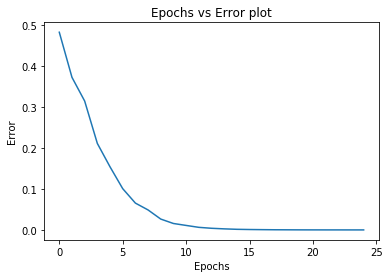

In [111]:
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Epochs vs Error plot')
plt.plot(err_plot)
plt.savefig('error_plot_iris.pdf')
plt.show()

In [110]:
loss_dictionary={'RBNN':err_plot}
df = pd.DataFrame(loss_dictionary)
df.to_excel('Loss_Restricted_BNN.xlsx')

In [103]:
print("Actual input:",X_new[56])
model2.predict(X_new[56],y[56])

Actual input: [0.55333328 0.56925129 0.53529583 0.52764485]
weights: by : {0: array([[ 0.97980011, -0.81375874],
       [ 1.49383526,  0.92672564],
       [-0.83123624,  0.3138375 ],
       [-0.1493553 , -0.0987939 ]]), 1: array([[2.41846885, 1.09350574],
       [1.59273732, 1.20586374]]), 2: array([[2.51140224, 4.19695374, 1.13243403],
       [1.91268587, 3.38232285, 1.93786031]])}
input: [0.55333328 0.56925129 0.53529583 0.52764485]
Actual output:1 and predicted ouput:1
